In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.rnn import GRUDecoder
from model.autoencoder import TabularEncoder
from data_processing.pipeline import encoding_pipeline, get_generic_name

import torch.nn as nn
import torch.nn.functional as F

import umap.umap_ as umap
import matplotlib.pyplot as plt
from model.utils import get_device, generate_predictions

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [4]:
importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:250].feature.map(lambda x: get_generic_name(x))
"Unique columns count: %s" %len(set(custom_pairs))

'Unique columns count: 205'

In [5]:
# check if sequences have been preprocessed (saves time)
if False: #os.path.exists('data/processed_data/sequences.pt'):
    sequences = torch.load('data/processed_data/sequences.pt')
else:
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)
    #torch.save(sequences, 'data/processed_data/sequences.pt')

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [6]:
from model.dataset import PretrainingDataset
pretrain_dataset = PretrainingDataset(sequences)

## Pretraining

In [14]:
### Initialization of the Autoencoder 
#ENCODING_SIZE = 64
BATCH_SIZE = 128
HIDDEN_SIZE = 64
ENCODING_SIZE = 64
NUM_HEADS = 4
DETECT_ANOMALY = False
SEQ_LEN = pretrain_dataset.get_seq_len()
VOCAB_SIZE = pretrain_dataset.get_vocab_size()

num_epochs = 10
learning_rate = 1e-4

assert HIDDEN_SIZE % NUM_HEADS == 0, "Check that the hidden size is divisible"
print(SEQ_LEN)

204


In [15]:
train_dataloader = DataLoader(pretrain_dataset, batch_size=BATCH_SIZE, shuffle=True)

encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                         embedding_size=HIDDEN_SIZE, 
                         output_size=ENCODING_SIZE, 
                         num_heads=NUM_HEADS,
                         num_layers=3, 
                         sequence_len=SEQ_LEN, 
                         layer_type = "mixture",
                         dropout=0.25,
                         decoder_output=3).to(device)
loss_cls = nn.CrossEntropyLoss(label_smoothing=0.01).to(device)
optimizer = optim.RAdam( encoder.parameters(), lr = learning_rate, weight_decay=1e-3, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min = 1e-5, last_epoch = -1)

Embedding Layer with Question Embdeddings


In [16]:
""" INPUT MODEL NAME BELOW (FOR CHECKPOINTS)"""
model_name = "exp"

encoder.train()
loss_metric = []
all_loss = []   # for plotting
######## ANNOMALY DETECTION
# torch.autograd.set_detect_anomaly(DETECT_ANOMALY)

for epoch in range(num_epochs):
    loss_epoch_metric = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, (year, seq) in loop_object :
        optimizer.zero_grad()
        year = year.to(device)
        input_seq = seq.to(device)
        

        seq, targs = generate_predictions(input_seq, vocab_size = VOCAB_SIZE, p = 0.3, missing_token_id=101)
        x = encoder.forward(year = year, seq=seq)
        loss = loss_cls(x.permute(0,2,1), targs.long())
        
        loss_epoch_metric.append(loss.detach().cpu().numpy())
        all_loss.append(loss_epoch_metric[-1])
        loss.backward()
        optimizer.step()
        loop_object.set_postfix_str("mean loss: %.4f"%np.mean(loss_epoch_metric[-100:]))
    ## After epoch end
    scheduler.step()
    loss_metric.append(np.mean(loss_epoch_metric))
    print(f'epoch {epoch} \t Loss: {loss_metric[-1]:.4g} and LR: {scheduler.get_last_lr()[0]:.5g}')
    torch.save(encoder.state_dict(), f'weights/{model_name}_{epoch}.pt')

Epochs 0: 702it [01:56,  6.01it/s, mean loss: 0.1268]


epoch 0 	 Loss: 0.2663 and LR: 9.7798e-05


Epochs 1: 702it [01:56,  6.00it/s, mean loss: 0.1051]


epoch 1 	 Loss: 0.1125 and LR: 9.1406e-05


Epochs 2: 702it [01:56,  6.00it/s, mean loss: 0.0900]


epoch 2 	 Loss: 0.09696 and LR: 8.145e-05


Epochs 3: 230it [00:38,  5.99it/s, mean loss: 0.0831]


KeyboardInterrupt: 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


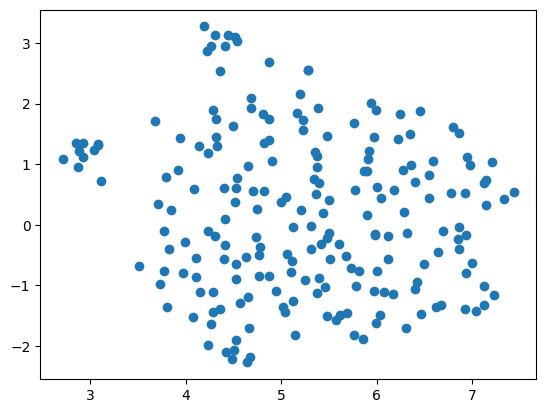

In [17]:
#import umap
w = encoder.embedding.question_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

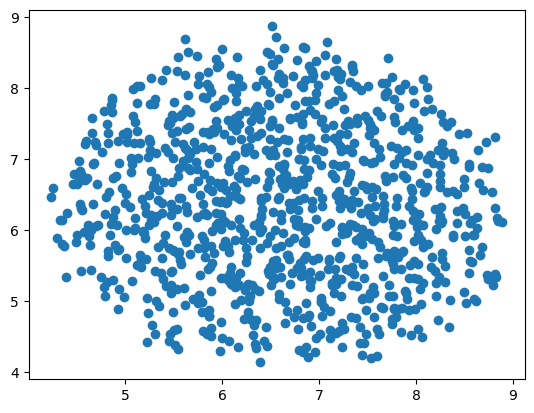

In [11]:
#import umap
w = encoder.embedding.answer_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

# Experimental Encoder (Only)

# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [ ]:
# its not everyone we have a target for, so we do restrict the data to 
# the ones with known outcomes
targets = targets[targets.new_child.notna()]
train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=0.2, random_state=42)

In [ ]:
rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

In [ ]:
# split data based on the splits made for the target
train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

In [ ]:
len(custom_pairs), len(set(custom_pairs))

(250, 205)

In [ ]:
from model.dataset import FinetuningDataset
train_dataset = FinetuningDataset(train_data, targets = targets)
test_dataset = FinetuningDataset(test_data, targets = targets)

rnn_batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)

In [ ]:
# ft - fine-tuning


SEQ_LEN = pretrain_dataset.get_seq_len()
VOCAB_SIZE = pretrain_dataset.get_vocab_size()

num_epochs_ft = 20
learning_rate_ft = 1e-3

encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                         embedding_size=HIDDEN_SIZE, 
                         output_size=ENCODING_SIZE, 
                         num_layers=3, 
                         sequence_len=SEQ_LEN, 
                         layer_type = "mixture",
                         dropout=0.3,
                         decoder_output=4).to(device)
encoder.load_state_dict(torch.load('weights/exp_0.pt'))

decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=2,
    max_seq_len=14,
    dropout=0.3,
    bidirectional=False,
    with_attention = True
).to(device)

# Define loss function and optimizer for RNN
ft_loss = nn.BCELoss()
ft_optimizer = torch.optim.NAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-2, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

# Training loop
decoder.train()
encoder.train()
print("Ready!")

Embedding Layer with Question Embdeddings
Ready!


In [ ]:
loss_per_epoch = []
for epoch in range(num_epochs_ft):
    # print(epoch)
    loss_per_step = []
    loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

        # Forward pass
        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

        #loss.backward(retain_graph=True)
        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs_ft}, Loss: {loss_per_epoch[-1]:.4f}")
    

Epochs 0: 79it [00:14,  5.43it/s, mean loss: 0.545]


Epoch 1/20, Loss: 0.5454


Epochs 1: 79it [00:14,  5.42it/s, mean loss: 0.532]


Epoch 2/20, Loss: 0.5324


Epochs 2: 79it [00:14,  5.42it/s, mean loss: 0.525]


Epoch 3/20, Loss: 0.5248


Epochs 3: 79it [00:14,  5.45it/s, mean loss: 0.514]


Epoch 4/20, Loss: 0.5143


Epochs 4: 79it [00:14,  5.42it/s, mean loss: 0.511]


Epoch 5/20, Loss: 0.5113


Epochs 5: 79it [00:14,  5.40it/s, mean loss: 0.509]


Epoch 6/20, Loss: 0.5089


Epochs 6: 79it [00:14,  5.42it/s, mean loss: 0.481]


Epoch 7/20, Loss: 0.4808


Epochs 7: 79it [00:14,  5.40it/s, mean loss: 0.348]


Epoch 8/20, Loss: 0.3475


Epochs 8: 79it [00:14,  5.39it/s, mean loss: 0.264]


Epoch 9/20, Loss: 0.2641


Epochs 9: 79it [00:14,  5.41it/s, mean loss: 0.208]


Epoch 10/20, Loss: 0.2079


Epochs 10: 79it [00:14,  5.43it/s, mean loss: 0.143]


Epoch 11/20, Loss: 0.1433


Epochs 11: 18it [00:03,  5.14it/s, mean loss: 0.109]


KeyboardInterrupt: 

In [ ]:

val_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
decoder.eval()
encoder.eval()
for batch in test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)

    encodings = encoder.get_encoding(input_year, input_seq).view(bs,ss, -1)
    mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()


    # Forward pass
    xx = decoder(encodings, mask)
    outputs = torch.nn.functional.sigmoid(xx).flatten()
    loss = ft_loss(outputs, labels)  
    val_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

In [ ]:
# Concatenate all the batches
predictions = (torch.tensor(preds) > 0.5).float()
probs = F.sigmoid(predictions)
actuals = torch.tensor(targets).flatten()

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
map_roc = average_precision_score(actuals.numpy(), probs.numpy())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-- mAP Score: {map_roc:.4f} --")

Precision: 0.7895
Recall: 0.6000
F1 Score: 0.6818
-- mAP Score: 0.5747 --


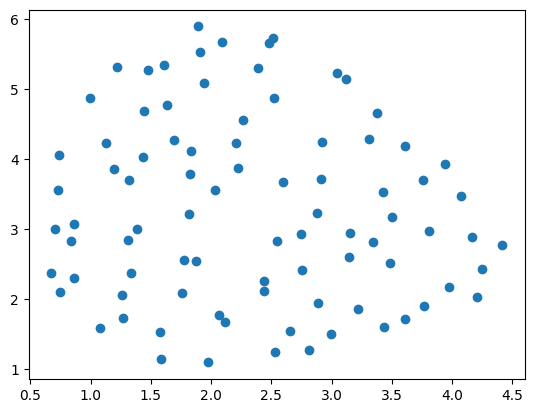

In [ ]:
#import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
w = encoder.embedding.question_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

# Cross validation

In [ ]:
from model.dataset import FinetuningDataset
from model.dataset import PretrainingDataset
from sklearn.model_selection import KFold
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [ ]:
n_features = 100

importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:n_features].feature.map(lambda x: get_generic_name(x))
sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)

rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [ ]:
def initialize(HIDDEN_SIZE=64,
               ENCODING_SIZE=64,
               NUM_COLS=44,
               num_epochs_ft=5,
               learning_rate_ft=1e-3,
               sequences = []
               ):

    pretrain_dataset = PretrainingDataset(sequences)
    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()

    encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                             embedding_size=HIDDEN_SIZE, 
                             output_size=ENCODING_SIZE, 
                             num_layers=1, 
                             sequence_len=SEQ_LEN, 
                             layer_type = "excel",
                             num_cols=NUM_COLS,
                             dropout=0.1
                             ).to(device).to(device=device)

    decoder = GRUDecoder(
        input_size=ENCODING_SIZE,
        hidden_size=HIDDEN_SIZE,
        num_layers=1,
        max_seq_len=14,
        dropout=0.15,
        bidirectional=False,
        with_attention = True
    ).to(device)

    # Define loss function and optimizer for RNN
    ft_loss = nn.BCELoss()
    ft_optimizer = torch.optim.NAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-2, decoupled_weight_decay=True)
    ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

    # Training loop
    decoder.train()
    encoder.train()

    return encoder, decoder, ft_optimizer, ft_loss, ft_scheduler

In [ ]:

def evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer):
    for i, batch in loop_object :        

        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  

        loss.backward()
        ft_optimizer.step()

    # On epoch end
    ft_scheduler.step()
    

In [ ]:
def evaluate(test_dataloader, encoder, decoder):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode.=
    decoder.eval()
    encoder.eval()
    for batch in test_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc
     


In [ ]:
HIDDEN_SIZE=64
ENCODING_SIZE=64
NUM_COLS=44
num_epochs_ft=10
learning_rate_ft=1e-3
rnn_batch_size = 10

n_splits = 4

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare for cross-validation
prec_per_fold = []
rec_per_fold = []
f1_per_fold = []
map_roc_per_fold = []

train_prec_per_fold = []
train_rec_per_fold = []
train_f1_per_fold = []
train_map_roc_per_fold = []

for fold, (train_index, val_index) in enumerate(kf.split(targets['nomem_encr'])):
    print(f'Fold: {fold}')
    train_person_ids = targets.loc[train_index, 'nomem_encr']
    test_person_ids = targets.loc[val_index, 'nomem_encr']
    
    encoder, decoder, ft_optimizer, ft_loss, ft_scheduler = initialize(
        HIDDEN_SIZE=64,
        ENCODING_SIZE=64,
        NUM_COLS=44,
        num_epochs_ft=1,
        learning_rate_ft=1e-3,
        sequences=sequences,
        )

    train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
    test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}
    
    train_dataset = FinetuningDataset(train_data, targets = targets)
    test_dataset = FinetuningDataset(test_data, targets = targets)

    train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)
    

    for epoch in range(num_epochs_ft):
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    
        evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer)

    precision, recall, f1, map_roc = evaluate(test_dataloader, encoder, decoder)
    precision_train, recall_train, f1_train, map_roc_train = evaluate(train_dataloader, encoder, decoder)
    
    prec_per_fold.append(precision)
    rec_per_fold.append(recall)
    f1_per_fold.append(f1)
    map_roc_per_fold.append(map_roc)

    train_prec_per_fold.append(precision_train)
    train_rec_per_fold.append(recall_train)
    train_f1_per_fold.append(f1_train)
    train_map_roc_per_fold.append(map_roc_train)


Fold: 0


Epochs 0: 0it [00:00, ?it/s]


NameError: name 'loss_per_step' is not defined

In [ ]:
print("Results on test set")
print("Prec:", ' '.join(f"{x:.3f}" for x in prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in map_roc_per_fold))

Results on test set
Prec: 0.857 0.667 0.629 0.938
Recall: 0.517 0.588 0.750 0.294
f1: 0.645 0.625 0.684 0.448
map roc: 0.557 0.477 0.524 0.422


In [ ]:
print('Results on training set')
print("Prec:", ' '.join(f"{x:.3f}" for x in train_prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in train_rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in train_f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in train_map_roc_per_fold))

Results on training set
Prec: 0.933 0.948 0.777 0.955
Recall: 0.721 0.907 0.956 0.261
f1: 0.813 0.927 0.857 0.410
map roc: 0.730 0.880 0.752 0.410
